<a href="https://colab.research.google.com/github/sohailkhanmarwat/CNN-LSTM/blob/master/cifar10_1_2_4_ssp_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
sys.path.append("..")

In [0]:
from keras.datasets import cifar10

In [0]:
#!rm 'keras_utils.py'
#!rm 'keras_utils (1).py'
#!rm 'keras_utils (2).py'
#!rm keras_utils2.py'
#!rm SpatialPyramidPooling.py'
#!ls -al

In [0]:
#from google.colab import files
#src = list(files.upload().values())[0]
#open('SpatialPyramidPooling.py','wb').write(src)


In [0]:
#download_utils.link_all_keras_resources()

In [8]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
#import SpatialPyramidPooling
#from keras_utils import reset_tf_session

1.13.1
2.2.4


In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [1]:
print("[INFO] loading CIFAR-10 data...")
from keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
((trainX, trainY), (testX, testY)) = cifar10.load_data()

[INFO] loading CIFAR-10 data...


Using TensorFlow backend.


170500096/170498071 [==============================] - 226s 1us/step


In [10]:
print("Train samples:", trainX.shape, trainY.shape)
print("Test samples:", testX.shape, testY.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


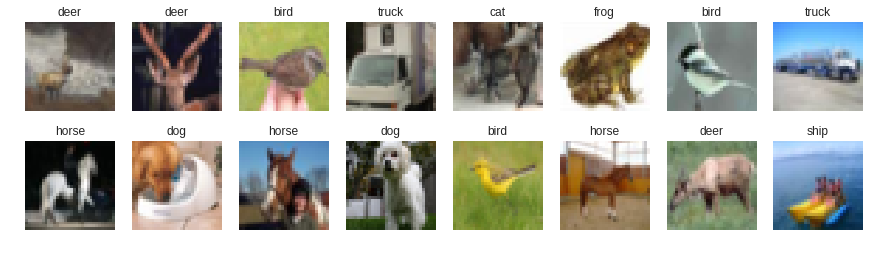

In [12]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainY))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(trainX[random_index, :])
        ax.set_title(cifar10_classes[trainY[random_index, 0]])
plt.show()

# Prepare Data

In [13]:
print("[INFO] Prepare Data...")
trainX2 = trainX.astype("float") / 255.0 - 0.5
testX2  = testX.astype("float") / 255.0 - 0.5

trainY2 = keras.utils.to_categorical(trainY, NUM_CLASSES)
testY2  = keras.utils.to_categorical(testY, NUM_CLASSES)


[INFO] Prepare Data...


In [19]:
print(testY.shape)
print(testY2.shape)

(10000, 1)
(10000, 10)


# Define CNN architecture

In [0]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from collections import defaultdict
from keras.models import save_model
from keras.layers import TimeDistributed


In [0]:
from keras.engine.topology import Layer
#import keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list  # [1, 2, 4]

        self.num_outputs_per_channel = sum([i * i for i in pool_list]) # 1*1 + 2*2 + 4*4 = 21

        super(SpatialPyramidPooling, self).__init__(**kwargs)
        
#        print(self.pool_list)
#        print(self.num_outputs_per_channel)
        
    def build(self, input_shape):
#        print("build is called")
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
#        print("conpute output shape is called")
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
#        print("get_config() is called")
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):
#        print("call is called")
        input_shape = K.shape(x)
#        print("Input Shape",input_shape.shape)
        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
            num_cols = input_shape[2]
            
        print(num_rows, num_cols)
        
        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]
        
#        print("row_length", row_length)
#        print("col_length", col_length)
        
        outputs = []

        if self.dim_ordering == 'th':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
#                print("num_pool_regions:",num_pool_regions)
#                print("pool_num: ",pool_num)
                for jy in range(num_pool_regions):
                    print("jy: ",jy)
                    for ix in range(num_pool_regions):
                        print("ix: ",ix)
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'tf':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
#                print("pool_num", pool_num)
#                print("num_pool_regions", num_pool_regions)
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        
                        
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
#                        print("xm.shape",xm.shape)
                        pooled_val = K.max(xm, axis=(1, 2))
#                        print("pooled_val",pooled_val)
                        outputs.append(pooled_val)

        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            #outputs = K.concatenate(outputs,axis = 1)
            outputs = K.concatenate(outputs)
            #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
            #outputs = K.permute_dimensions(outputs,(3,1,0,2))
            #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))
#        print("outputs.shape",outputs.shape)
        return outputs


In [0]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


In [0]:
class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        import tqdm
        tqdm.monitor_interval = 0  # workaround for https://github.com/tqdm/tqdm/issues/481
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)

In [0]:
#import tqdm_utils


class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()

In [0]:
num_timesteps = 10

def make_model():
  
  model = Sequential()
  input_dim = (32, 32, 3)
  model.add(Conv2D(16, (3,3), padding="same", input_shape=(32, 32, 3)))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(32, (3,3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, (3,3), padding="same"))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(LeakyReLU(0.1))
  ##model.add(MaxPooling2D(2,2))
  ##model.add(Dropout(0.25))
  ssp_layer = SpatialPyramidPooling([1, 2, 4])
  model.add(ssp_layer)
  # model.add(LSTM(256))
  # model.add(Dens)
  # model.add(Dropout(0.25))
  # model.add(Flatten())
  #model.add(Dense(256))
  # model.add(LeakyReLU(0.1))
  
  # model.add(Dense(NUM_CLASSES))
  # model.add(Activation("softmax"))
  #LSTM
  lstm_model = Sequential()
  input_shape=(num_timesteps,) + input_dim
  lstm_model.add(TimeDistributed(model, input_shape=input_shape))
  lstm_model.add(LSTM(256, return_sequences=True))
  #lstm_model.add(LeakyReLU(0.1))
  #model.add(Dropout(0.25))
  #lstm_model.add(LSTM(256))
  #lstm_model.add(LeakyReLU(0.1))
  #lstm_model.add(Dropout(0.25)) #added
  #lstm_model.add(Dense(256))
  #lstm_model.add(LeakyReLU(0.1))
  #lstm_model.add(Dropout(0.25)) #added
  lstm_model.add(Dense(NUM_CLASSES, activation='softmax'))

  #model.compile(loss=’binary_crossentropy’, optimizer=’adam’, metrics=[‘accuracy’])
  
  
  return lstm_model

In [0]:
#!ls -al

In [76]:
s = reset_tf_session()
model = make_model()
model.summary()

Tensor("spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)
Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 1344)          32832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           1639424   
_________________________________________________________________
dense_1 (Dense)              (None, 10, 10)            2570      
Total params: 1,674,826
Trainable params: 1,674,826
Non-trainable params: 0
_________________________________________________________________


# Training Network

In [77]:

print("[INFO] training network...")
#sgd = SGD(0.01)
#model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

learning_rate = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = reset_tf_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=learning_rate),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(self, epoch):
    return learning_rate * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))
       


[INFO] training network...
Tensor("spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)
Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)


# Add Checkpoints

In [78]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 7
print(trainX2.shape)
trainX3 = np.reshape(trainX2,(-1,num_timesteps,trainX2.shape[1],trainX2.shape[2],3))
print(trainX3.shape)
testX3 = np.reshape(testX2,(-1,num_timesteps,testX2.shape[1],testX2.shape[2],3))
print(testX3.shape)


(50000, 32, 32, 3)
(5000, 10, 32, 32, 3)
(1000, 10, 32, 32, 3)


In [79]:
trainY3 = np.reshape(trainY2,(-1,num_timesteps,10))
print(trainY3.shape)
testY3 = np.reshape(testY2,(-1,num_timesteps,10))
print(testY3.shape)

(5000, 10, 10)
(1000, 10, 10)


# Fit Model

In [80]:
# fit model
model.fit(
    trainX3, trainY3,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    validation_data=(testX3, testY3),
    shuffle=True,
    verbose=0,
    initial_epoch= last_finished_epoch or 0
)



Learning rate: 0.0049973666

Epoch 1/10



Model saved in cifar.000.hdf5
Learning rate: 0.004997368

Epoch 2/10



Model saved in cifar.001.hdf5
Learning rate: 0.004997368

Epoch 3/10



Model saved in cifar.002.hdf5
Learning rate: 0.004997368

Epoch 4/10



Model saved in cifar.003.hdf5
Learning rate: 0.004997368

Epoch 5/10



Model saved in cifar.004.hdf5
Learning rate: 0.004997368

Epoch 6/10



Model saved in cifar.005.hdf5
Learning rate: 0.004997368

Epoch 7/10



Model saved in cifar.006.hdf5
Learning rate: 0.004997368

Epoch 8/10



Model saved in cifar.007.hdf5
Learning rate: 0.004997368

Epoch 9/10



Model saved in cifar.008.hdf5
Learning rate: 0.004997368

Epoch 10/10



Model saved in cifar.009.hdf5


In [0]:
# save weights to file
model.save_weights("weights.h5")

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [0]:
# make test predictions

y_pred_test = model.predict_proba(testX3)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

In [74]:
print(testY2.shape)
print(y_pred_test_classes.shape)
y_pred_test = model.predict(testX)
print(y_pred_test.shape)
#print(y_pred_test_classes.max(axis=1))
#print(testY3.argmax(axis=1))
print("Test accuracy:", accuracy_score(testY3.argmax(axis=1), y_pred_test.argmax(axis=1)))

(10000, 10)
(1000, 10)


ValueError: ignored

ValueError: ignored

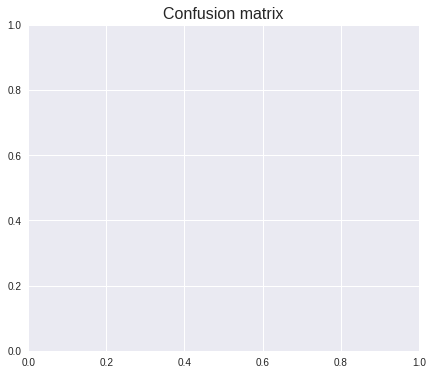

In [51]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(testY3, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(testY3, y_pred_test_classes))

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


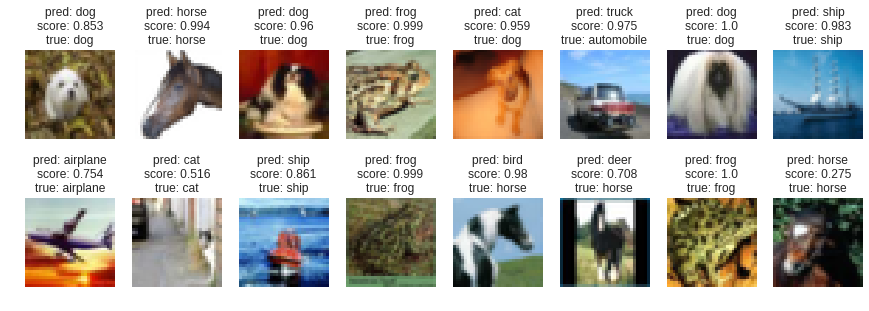

In [0]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(testY))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(testX[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[testY[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

In [0]:
s = reset_tf_session()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

Tensor("spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)
Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice:0", shape=(), dtype=int32) Tensor("time_distributed_1/spatial_pyramid_pooling_1/strided_slice_1:0", shape=(), dtype=int32)


In [0]:
# all weights we have
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 1344)           32832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            1639424   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,870,666
Trainable params: 1,870,666
Non-trainable params: 0
_________________________________________________________________


In [0]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x - np.mean(x))/np.square(np.std(x))*0.05### YOUR CODE HERE

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5)*255### YOUR CODE HERE
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [0]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

In [0]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

In [0]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)